# Subject data to catatonia prediction 
Data includes: 
    - Bush-Francis pre/post treatment
    - Drugs and doses pre/post treatment for antipsychotic, lamotragine and benzos
* Drug doses are used to calculate target concentration and target occupation.
* Target occupations are coupled to Wilson-Cowan model parameters. 
* Model parameters are optimized for catatonia symptoms.

In [1]:
%matplotlib inline
from IPython.display import display   # To print DataFrames nicely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
root_path = '/home/ec2-user/SageMaker/cascadia-behavioral-healthcare'
sys.path.insert(1, root_path + '/src')
data_path = root_path + '/data' # location of data files

### Transform target occupations to Wilson_Cowan model parameters
Wilson-Cowan description of cortical states generated by excitatory-inhibitory neural pools.
Population of excitatory and inhibitory neurons:
$$\tau_0 \dot{u_0} = -u_0 + f(w_{00}u_0 + w_{01}u_1 + I_0)$$
$$\tau_1 \dot{u_1} = -u_1 + f(w_{10}u_0 + w_{11}u_1 + I_1)$$
where for the E-I circuit, $w_{00}<0$ and $w_{01}<0$.

### Define class to convert clinical dose data to Wilson-Cowan model parameters

In [2]:
# Load clinical data
data_file_name = 'synth_drug_BF__07212022.csv'
# synth_drug_BF = pd.read_csv(data_path + '/' + data_file_name)
synth_drug_BF = pd.read_csv(data_file_name)
synth_drug_BF.drop('Unnamed: 0',axis=1, inplace=True)
synth_drug_BF.head(2)

,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,pre_Fluphenazine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
0,a,18,6,NaN,NaN,NaN,20.0,3.0,NaN,NaN,...,NaN,4.0,800.0,NaN,NaN,500.0,NaN,2.0,NaN,NaN
1,c,14,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,550.0,NaN,NaN,450.0,NaN,NaN,NaN,NaN


In [3]:
import neural_mech.conc_effect as ce     # Custom code for calculating PK effects

# Seperate into pre/post-treatment datasets
pre_clinical, post_clinical = ce.seperate_clinical_pre_post(synth_drug_BF)
display(pre_clinical.head(2))
display(post_clinical.head(2))

# Instantiate data processing objects for pre & post data
d2a_pre = ce.Dose_Conversion(pre_clinical)
d2a_post = ce.Dose_Conversion(post_clinical)

# Load pharmacokinetic information on relevant drugs
drugParams = pd.read_excel(data_path + '/' + 'drugParams.xls', sheet_name='params')
d2a_pre.load_pharmacokinetic_info(drugParams)
d2a_post.load_pharmacokinetic_info(drugParams)

# Load drug affinity data and calculate target occupancy
pdspDataFile = 'kidb110121.txt'
kidb110121 = pd.read_csv(data_path + '/' + pdspDataFile, 
                                header=None, sep="\t", error_bad_lines=False, 
                                engine='python')
d2a_pre.load_drug_affinities(kidb110121)
d2a_post.load_drug_affinities(kidb110121)

,patient,pre_total_bf,Benztropine,Carbamazepine,Chlorpromazine,Citalopram,Clonazepam,Clozapine,Fluphenazine,Fluvoxamine,...,Lamotrigine,Lorazepam,Loxapine,Olanzapine,Oxcarbazepine,Risperidone,Sertraline,Zolpidem,Quetiapine,Valproic_acid
0,a,18,NaN,NaN,NaN,20.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,2000.0
1,c,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,NaN,NaN,NaN,NaN,NaN,1250.0


,patient,post_total_bf,Benztropine,Clonazepam,Clozapine,Valproic_acid,Fluvoxamine,Lamotrigine,Lorazepam,Melatonin,Olanzapine,Sertraline
0,a,6,NaN,4.0,800.0,NaN,NaN,500.0,NaN,2.0,NaN,NaN
1,c,4,NaN,3.0,550.0,NaN,NaN,450.0,NaN,NaN,NaN,NaN


In [4]:
# Calculate Wilson-Cowan parameter values corresponding to doses
model_param_pre = d2a_pre.dose_to_model(p_wt=0.35)
display(model_param_pre.head())

model_param_post = d2a_post.dose_to_model(p_wt=0.35)
display(model_param_post.head())

,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,0.997992,1.001722,1.002889,1.019348,1.021429,0.998278,1.001972
1,1.0,0.998242,1.001132,1.002188,1.000000,1.001740,0.998868,1.001740
2,1.0,0.999654,1.000038,1.000853,1.000000,1.000346,0.999962,1.000346
3,1.0,0.999134,1.000713,1.002161,1.000000,1.000860,0.999287,1.000860
4,1.0,0.998764,1.000058,1.000886,1.000000,1.001236,0.999942,1.001236


,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,0.998449,1.000471,1.036300,1.025330,1.026988,0.994959,0.996950
1,1.0,0.998909,1.000330,1.029218,1.019348,1.020496,0.995555,0.996957
2,1.0,0.998907,1.000334,1.029922,1.022366,1.023526,0.995095,0.996500
3,1.0,0.999485,1.000165,1.017890,1.006696,1.007221,0.996176,0.996849
4,1.0,0.998459,1.000207,1.010028,1.011552,1.013142,0.995677,0.997402


In [5]:
print(drugParams[['param','Clozapine','Olanzapine',
                  'Lamotrigine','Clonazepam','Lorazepam']].to_latex(index=False)) 

\begin{tabular}{lrrrrr}
\toprule
             param &  Clozapine &  Olanzapine &  Lamotrigine &  Clonazepam &  Lorazepam \\
\midrule
   bioavailability &       0.65 &        0.87 &        0.950 &         0.9 &       0.85 \\
  clearance (L/hr) &      31.00 &       21.80 &        2.100 &         2.1 &       4.30 \\
 blood/brain ratio &       1.00 &        1.00 &        1.900 &         1.0 &       1.53 \\
   mole wt (g/mol) &     326.82 &      312.43 &      256.091 &       315.7 &     321.20 \\
          pk\_param &       1.00 &        1.00 &        1.000 &         0.3 &      10.00 \\
\bottomrule
\end{tabular}



In [6]:
print(d2a_post.ki_receptor_drug[['DOPAMINE', '5-Hydroxy Tryptamine','Clozapine','Olanzapine',
                  'Lamotrigine','Clonazepam','Lorazepam']].to_latex(index=True))

\begin{tabular}{lrrrrrrr}
\toprule
{} &      DOPAMINE &  5-Hydroxy Tryptamine &  Clozapine &  Olanzapine &  Lamotrigine &  Clonazepam &  Lorazepam \\
receptors &               &                       &            &             &              &             &            \\
\midrule
D1        &    130.000000 &           9690.000000 &       89.0 &       25.00 &      10000.0 &     10000.0 &    10000.0 \\
D2        &    469.428571 &          10000.000000 &       28.0 &        3.00 &      10000.0 &     10000.0 &    10000.0 \\
5-HT1A    &   8248.000000 &              2.789167 &      104.8 &      610.00 &      10000.0 &     10000.0 &    10000.0 \\
5-HT2A    &  10000.000000 &             20.800117 &        1.0 &        1.48 &      10000.0 &     10000.0 &    10000.0 \\
M1        &  10000.000000 &          10000.000000 &        1.4 &        2.00 &      10000.0 &     10000.0 &    10000.0 \\
\bottomrule
\end{tabular}



Number of subjects = 58


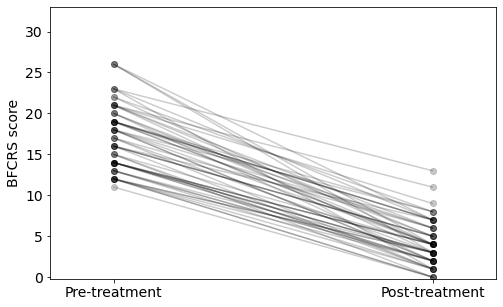

In [7]:
import seaborn as sns                   # Pretty graphing commands

print('Number of subjects =', len(pre_clinical))
fig, ax1 = plt.subplots(1,1,figsize=(8,5))
for i in pre_clinical['pre_total_bf'].reset_index(drop=True).index:
    ax1.plot([0],pre_clinical['pre_total_bf'].reset_index(drop=True).iloc[i], 'ok', alpha=0.2)
    ax1.plot([1],post_clinical['post_total_bf'].reset_index(drop=True)[i], 'ok', alpha=0.2)
    ax1.plot([0,1], [pre_clinical['pre_total_bf'].reset_index(drop=True)[i], post_clinical['post_total_bf'].reset_index(drop=True)[i]], '-k', alpha=0.2)
ax1.set_xlim(-0.2,1.2)
ax1.set_xticks([0,1])
ax1.set_ylabel('BFCRS score', fontsize=14)
plt.ylim(-0.2,33)
ax1.tick_params(axis='both', which='major', labelsize=14) 
# sns.despine()
labels = [item.get_text() for item in ax1.get_xticklabels()]
labels[0] = 'Pre-treatment'
labels[1] = 'Post-treatment'
ax1.set_xticklabels(labels);
# fig.savefig('./figs_publ/potential_dose_lor.tiff', dpi=300, format="tiff", bbox_inches = "tight")

In [57]:
print('Mean pre BF:', np.mean(pre_clinical['pre_total_bf']))
print('Mean post BF:', np.mean(post_clinical['post_total_bf']))
diff_mean_bf = np.mean(pre_clinical['pre_total_bf'])-np.mean(post_clinical['post_total_bf'])
print('Difference:', round(diff_mean_bf, 1))

Mean pre BF: 17.275862068965516
Mean post BF: 4.086206896551724
Difference: 13.2


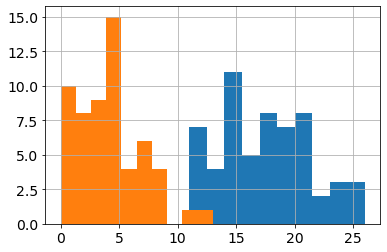

In [55]:
pre_clinical['pre_total_bf'].hist()
post_clinical['post_total_bf'].hist();

Ave pre-med count: 2.9827586206896552
Median pre-med count: 3.0
Std pre-med count: 1.4688744863000809
Ave post-med count: 3.4827586206896552
Median post-med count: 3.0
Std post-med count: 0.6816229165476878


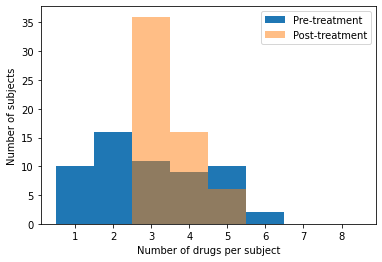

In [8]:
fig = plt.figure()
pre_clinical[pre_clinical.keys()[2:]].count(axis=1).hist(bins=8, 
                                                         range=[0.5,8.5], 
                                                         label='Pre-treatment')
post_clinical[post_clinical.keys()[2:]].count(axis=1).hist(bins=8, 
                                                           range=[0.5,8.5], 
                                                           alpha=0.5, label='Post-treatment')
print('Ave pre-med count:', pre_clinical[pre_clinical.keys()[2:]].count(axis=1).mean())
print('Median pre-med count:', pre_clinical[pre_clinical.keys()[2:]].count(axis=1).median())
print('Std pre-med count:', pre_clinical[pre_clinical.keys()[2:]].count(axis=1).std())
print('Ave post-med count:', post_clinical[post_clinical.keys()[2:]].count(axis=1).mean())
print('Median post-med count:', post_clinical[post_clinical.keys()[2:]].count(axis=1).median())
print('Std post-med count:', post_clinical[post_clinical.keys()[2:]].count(axis=1).std())
ax1.tick_params(axis='both', which='major', labelsize=14) 
plt.xlabel('Number of drugs per subject')
plt.ylabel('Number of subjects')
plt.grid(b=None)
plt.legend();
fig.savefig('./figs_publ/bf_pre_post_data.tiff', dpi=300, format="tiff", 
            bbox_inches = "tight")

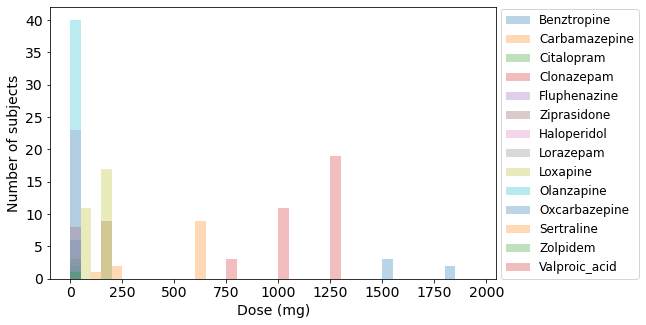

In [9]:
fig = plt.figure(figsize=(8,5))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.grid(False)
pre_drugs = pre_clinical.columns[2:]
max_dose = pre_clinical[pre_drugs].max().max()
max_bar = 0
for d in pre_drugs:
    if pre_clinical[d].sum()>0:
        histo = plt.hist(pre_clinical[d], bins=np.arange(0, max_dose, 50), alpha=0.3, label=d)
plt.legend()
plt.legend(loc=[1.01, 0.])
ax1.tick_params(axis='both', which='major', labelsize=14) 
plt.xlabel('Dose (mg)')
plt.ylabel('Number of subjects');
fig.savefig('./figs_publ/meds_pre.tiff', dpi=300, format="tiff", bbox_inches = "tight")

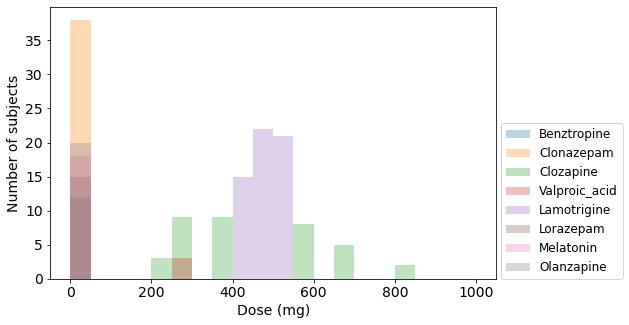

In [10]:
fig = plt.figure(figsize=(8,5))
plt.grid(False)
post_drugs = post_clinical.columns[2:]
max_dose = post_clinical[post_drugs].max().max()
max_bar = 0
for d in post_drugs:
    if post_clinical[d].sum()>0:
        histo = plt.hist(post_clinical[d], bins=np.arange(0, max_dose, 50), 
                         alpha=0.3, label=d)
plt.legend()
plt.legend(loc=[1.01, 0.])
plt.xlabel('Dose (mg)')
plt.ylabel('Number of subjects');
fig.savefig('./figs_publ/meds_post.tiff', dpi=300, format="tiff", bbox_inches = "tight")

Combine the ON/OFF Bush-Francis Total score with the model parameters

In [11]:
model_param_pre['BF_total'] =  pre_clinical['pre_total_bf'] 
model_param_post['BF_total'] =  post_clinical['post_total_bf'] 
model_param_pre.loc['control','BF_total'] = 0
model_param_post.loc['control','BF_total'] = 0

print (len(model_param_pre), len(model_param_post))
display(model_param_pre.tail())
display(model_param_post.tail())

param_BF = model_param_pre.append(model_param_post)
print(param_BF.tail(1).index)
param_BF.drop(param_BF.tail(1).index, inplace=True)
param_BF.reset_index(drop=True, inplace=True)
print (len(param_BF))
param_BF.tail()

59 59


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
54,1.0,0.999384,1.000885,1.001558,1.0,1.000609,0.999115,1.000609,17.0
55,1.0,0.998945,1.001127,1.002651,1.0,1.001041,0.998873,1.001041,16.0
56,1.0,0.998945,1.001127,1.002651,1.0,1.001041,0.998873,1.001041,11.0
57,1.0,0.999654,1.000038,1.000853,1.0,1.000346,0.999962,1.000346,20.0
control,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.0


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
54,1.0,0.999483,1.000168,1.018578,1.009949,1.010480,0.995716,0.996392,3.0
55,1.0,0.998459,1.000206,1.010692,1.011552,1.013142,0.995220,0.996943,5.0
56,1.0,0.999291,1.000108,1.007947,1.011552,1.012285,0.995775,0.996582,0.0
57,1.0,0.998461,1.000203,1.010023,1.009949,1.011530,0.995681,0.997401,4.0
control,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


Index(['control'], dtype='object')
116


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
111,1.0,0.999292,1.000105,1.007280,1.044520,1.045318,0.996235,0.997039,0.0
112,1.0,0.999483,1.000168,1.018578,1.009949,1.010480,0.995716,0.996392,3.0
113,1.0,0.998459,1.000206,1.010692,1.011552,1.013142,0.995220,0.996943,5.0
114,1.0,0.999291,1.000108,1.007947,1.011552,1.012285,0.995775,0.996582,0.0
115,1.0,0.998461,1.000203,1.010023,1.009949,1.011530,0.995681,0.997401,4.0


### Load the neural model generator
Define a function to set the model parameters and compute the fixed points.

0 1.5604561260980891
1 1.7843872443532278
2 1.756817992901594
3 1.7566161700668412
4 1.7741030851879684
5 1.7843872443532278
6 1.7564677676696356
7 1.7588742212539836
8 1.0709476448081947
9 1.7497086624828313
10 1.763254554324599
11 1.7694610549413101
12 1.2694217754009975
13 1.756817992901594
14 1.7339718418181949
15 1.4937042492024046
16 1.7906098217395352
17 1.756817992901594
18 1.4887781080656963
19 1.492656046730667
20 1.777273421475149
21 1.7564677676696356
22 1.7843872443532278
23 1.7764280339090346
24 1.756817992901594
25 1.7670603610922815
26 1.7617355514378243
27 1.7691847988963714
28 1.5007585354723827
29 1.5339408011772038
30 1.4981000550061694
31 1.292075786020288
32 1.538154772486768
33 1.7919836548188495
34 1.77200928854267
35 1.7796836062908084
36 1.7694610549413101
37 1.7695389917807445
38 1.7617355514378243
39 1.5604561260980891
40 1.764739957887778
41 1.779029175197545
42 1.756817992901594
43 1.7564677676696356
44 1.5469999521166995
45 1.761472119896109
46 1.77968360

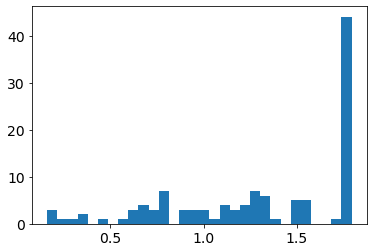

In [12]:
import neural_mech.neural_circuit as ncircuit
nc = ncircuit.Neural_Circuit()

model_pars = ['mu0','mu1','th0','th1','w00', 'w01','w10','w11']
params_df = param_BF[model_pars].reset_index(drop=True)
barriers = []
for index, row in params_df.iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
    print(index, barrier)

plt.hist(barriers, bins=30);

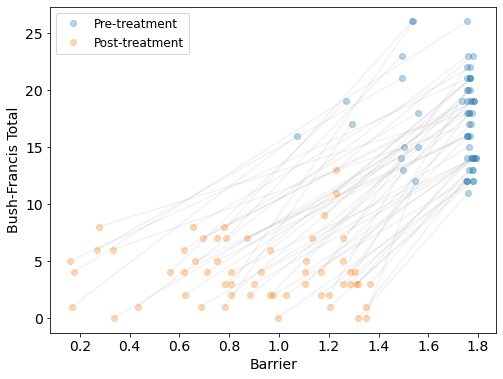

In [13]:
fig = plt.figure(figsize=(8,6))
num_subj = int(len(barriers)/2)
plt.plot(barriers[:num_subj], 
         param_BF.head(num_subj)['BF_total'], 'o', alpha=0.3, label='Pre-treatment')
plt.plot(barriers[num_subj:], 
         param_BF.tail(num_subj)['BF_total'], 'o', alpha=0.3, label='Post-treatment')
for idx in range(num_subj):
    plt.plot([barriers[idx],barriers[num_subj+idx]], 
             [param_BF.loc[idx,'BF_total'],param_BF.loc[num_subj+idx,'BF_total']], 
             color='gray', alpha=0.1)
plt.legend()
plt.xlabel('Barrier')
plt.ylabel('Bush-Francis Total');
# fig.savefig('./figs_publ/subjects_barrier_bf.tiff', dpi=300, format="tiff")

11.293198276381483 -3.9623405873060022 0.7304021714876925


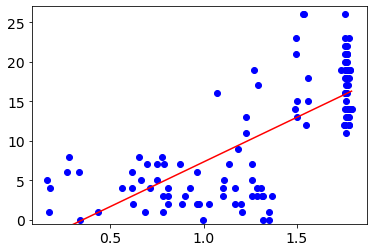

In [14]:
from scipy import stats

# Test linear fit for barrier-BF
x = barriers
y = param_BF['BF_total']
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(gradient, intercept, r_value)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'ob')
plt.plot(x1,y1,'-r')
plt.ylim(-0.5,27);

In [92]:
# x = barriers
# y = param_BF['BF_total']
(p_cor, p_val) = stats.pearsonr(x,y)
print('Pearson correlation coefficient:', round(p_cor, 4), round(p_cor**2, 4))
print('Two-tailed p-value:', p_val)
(s_cor, p_val) = stats.spearmanr(x,y)
print('Spearman correlation coefficient:', round(s_cor, 4))
print('Two-tailed p-value:', p_val)

Pearson correlation coefficient: 0.7304 0.5335
Two-tailed p-value: 1.3519910802604787e-20
Spearman correlation coefficient: 0.6895
Two-tailed p-value: 1.1423608594178394e-17


In [41]:
def effect_size(pop1, pop2):
    stdev = np.sqrt(np.std(pop1)**2 + np.std(pop2)**2)
    effect_size = (np.mean(pop1) - np.mean(pop2))/stdev
    return effect_size

print ('Effect size', effect_size(barriers[:num_subj], barriers[num_subj:]))
f_val, p_val = stats.f_oneway(barriers[:num_subj], barriers[num_subj:])  
print ('p-val:', p_val)

Effect size 2.139680054860424
p-val: 2.9930305709943744e-31


In [39]:
import scipy
scipy.__version__

'1.5.4'

In [44]:
f_val, p_val = stats.ttest_ind(barriers[:num_subj],barriers[num_subj:])
print ('p-val:', p_val)

p-val: 2.9930305709943227e-31


In [62]:
print('Mean pre barrier:', np.mean(barriers[:num_subj]))
print('Max pre barrier:', np.max(barriers[:num_subj]))
print('Mean post barrier:', np.mean(barriers[num_subj:]))
diff_mean_barrier = np.mean(barriers[:num_subj])-np.mean(barriers[num_subj:])
print('Difference:', round(diff_mean_barrier, 2))
print('Scale BF/barrier', diff_mean_bf/diff_mean_barrier)

Mean pre barrier: 1.6960867703145739
Max pre barrier: 1.7919836548188495
Mean post barrier: 0.8972220004505116
Difference: 0.8
Scale BF/barrier 16.51049798410586


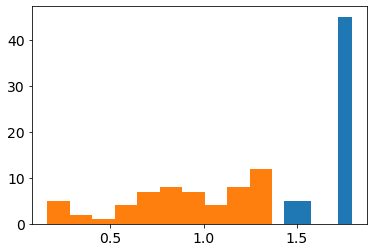

In [59]:
plt.hist(barriers[:num_subj])
plt.hist(barriers[num_subj:]);

In [63]:
diff_mean_bf, diff_mean_barrier

(13.189655172413792, 0.7988647698640623)

In [77]:
# Statistics for population barrier reduction
barrier_bf_change = pd.DataFrame({'barrier_pre': barriers[:num_subj],'barrier_post': barriers[num_subj:],
                                  'bf_pre': list(param_BF.head(num_subj)['BF_total']), 
                                  'bf_post': list(param_BF.tail(num_subj)['BF_total'])})
barrier_bf_change['barrier_change'] = barrier_bf_change['barrier_pre'] - barrier_bf_change['barrier_post']
barrier_bf_change['bf_change'] = barrier_bf_change['bf_pre'] - barrier_bf_change['bf_post']
barrier_bf_change.describe()

,barrier_pre,barrier_post,bf_pre,bf_post,barrier_change,bf_change
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,1.696087,0.897222,17.275862,4.086207,0.798865,13.189655
std,0.150028,0.345445,3.919332,2.767509,0.322612,3.337490
min,1.070948,0.161123,11.000000,0.000000,0.198633,9.000000
25%,1.751398,0.689615,14.000000,2.000000,0.527539,11.000000
50%,1.761472,0.913755,17.000000,4.000000,0.756885,12.000000
75%,1.772009,1.204331,20.000000,6.000000,1.002226,15.000000
max,1.791984,1.366654,26.000000,13.000000,1.595345,23.000000


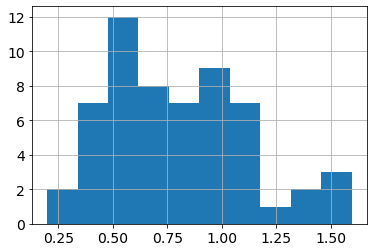

In [90]:
barrier_bf_change['barrier_change'].hist();
# barrier_bf_change['bf_change'].hist();

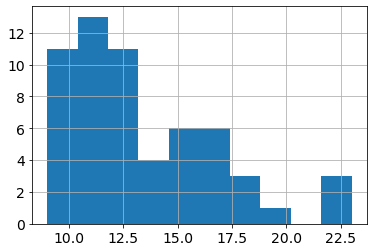

In [91]:
barrier_bf_change['bf_change'].hist();

In [94]:
(p_cor, p_val) = stats.pearsonr(barrier_bf_change['barrier_change'], barrier_bf_change['bf_change'])
print(p_cor, p_val)
p_cor**2

0.3361676889352542 0.009879833102393895


0.11300871508406984

3.4777219051901516 10.411425662972855 0.33616768893525406


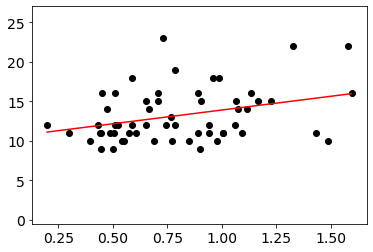

In [98]:
x = barrier_bf_change['barrier_change']
y = barrier_bf_change['bf_change']
gradient, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(gradient, intercept, r_value)
mn=np.min(x)
mx=np.max(x)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(x,y,'ok')
plt.plot(x1,y1,'-r')
plt.ylim(-0.5,27);